[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mravanba/comp451/blob/master/PCA.ipynb)

# Principal Component Analysis (PCA)
Consider having $N$ samples with $D$ features in $X \in \!R^{N \times D}$, with $D < N$.
In PCA we try to find an orthonormal transformation of data to a new coordinate. Using orthonormal $W \in \!R^{D \times D'}$ for the purpose we want
the projection to the first coordinate, have the highest variance, the second coordinate have the second highest and so on ...
Writing $X W$ for the coordinate transform, each column of $W$ denoted by $w$ maps $X$ to one of these coordinates; so the first coordinate is $X w_1 = z_1 \in \!R^{n}$. 
Maximizing the variance of projections in $z_1$ we get:
$$
\max_{w_1, ||w_1||_2=1} \frac{1}{N} z_1^\top z_1 = \max_{w_1, ||w_1||_2=1} \frac{1}{N} w_1^\top X^\top X w_1
$$
The constraint on the norm of $w_1$ comes from orthonormality of $W$ and in maximizing variance this way we have assumed each feature in $X$ has a zero mean.
In the above equation $\Sigma = \frac{1}{N} X^\top X$ is called *covariance matrix* (recall from the multivariate Gaussian lecture).
Covariance matrix is *positive semi-definite and symmetric*. Such matrices can be decomposed as 
$\Sigma = Q \Lambda Q^\top$ where $Q$ is orthonormal, containing eigenvectors, and $\Lambda$ has eigenvalues $\lambda_1,\ldots,\lambda_d$ on its diagonal. The maximization above becomes
$$
\max_{||w_1||_2=1} w_1^\top Q \Lambda Q^\top w_1 = \lambda_1
$$
where the maximizing $w_1$ is the first eigenvector $Q_{:,1}$. Similarly the second principal direction is the second eigenvector of the covariance matrix $C$, and so on ...
So eigenvectors give us the new coordinates, and since they are unit length we can project to them using product $X Q$.

Dimensionality reduction amounts to using the first $D' < D$ component in the new coordinates $X Q_{:,:D'}$, instead of $X$.
If we want to see what the compressed data looks like in the original coordinates we can use $Q^\top$ to move back to the original coordinate. In other words $||X - X Q_{:,:c} Q_{:,:c}^\top||_F$ gives us our compression error. 

Let's create simple 2D data and extract and perform PCA.

In [41]:
import numpy as np
#%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace
import warnings
warnings.filterwarnings('ignore')

In [42]:
N = 20
x0 = np.random.randn(N) #first row of x
x1 = 1.5*x0 + np.random.randn(N) #second row of x
x = np.column_stack((x0,x1)) #note that x already has mean 0
c = x.T @ x / N            # gives us the covariance matrix
lam, q = np.linalg.eigh(c) # lam(bda) is vector of eigenvalues in ascending order, columns of q are eigenvectors

Now lets plot the projections into the first and second principal direction. For this we project using $X Q_{:,1} Q_{:,1}^\top$ to get the coordinates in the original coordinate system.

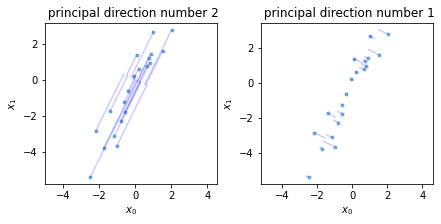

In [43]:
fig, axes = plt.subplots(ncols=2, nrows=1, constrained_layout=True, figsize=(6, 3))
for d in range(2):
    xqqt = x @ q[:,[d]] @ q[:,[d]].T        #projected points in the original coordinate system 
    axes[d].plot(x0, x1, '.', alpha=.5)     #plot the data in 2D 
    for i in range(N):
        #get the line to the projected points in the corressponding direction 
        axes[d].plot([x[i,0], xqqt[i,0]],  [x[i,1],xqqt[i,1]], '-b', alpha=.2)
        axes[d].set_aspect('equal', 'datalim')
        axes[d].set_title(f' principal direction number {2-d}')
        axes[d].set_xlabel(r'$x_0$')
        axes[d].set_ylabel(r'$x_1$')
#plt.axes().set_aspect('equal', 'datalim')
plt.show()

## Singular Value Decomposition (SVD)

Another way to do PCA is using direct SVD decomposition of $X$ 
$$
X = \underbrace{U}_{n\times d} \underbrace{S}_{d\times d} \underbrace{V^\top}_{d \times d}
$$
To see the connection to derivation using the covariance matrix, note:
$$
\Sigma = \frac{1}{N}X^\top X = \frac{1}{N} V S U^\top U S V^\top = \frac{1}{N}  V S^2 V^\top =  Q \Lambda Q^\top
$$
Since the decomposition of $\Sigma$ in the form above is unique, the last equality means $V = Q$, and right singular vectors (columns of $V$) are the *principal directions*.
How about principal component coefficients? previously we got them using $X Q$ (or using a subset of columns of $Q$). However, this means
$$
X Q = U S V^\top V = U S
$$
To project back to original coordinates, similar to the previous derivation we multiply by $Q^\top = V^\top$ to get $U S V^\top = X$.

Therefore, if we zero some of the eigenvalues in $S$ we get the projections.

since $S$ is diagonal matrix, in `numpy.linalg.svd` it is returned in the form a vector.
Lets create simple 2D data and do some experiments.

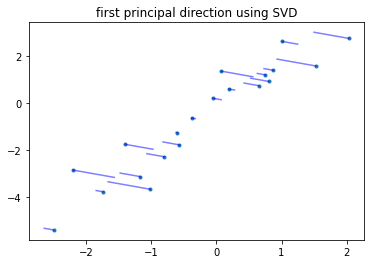

In [44]:
u,s,vt = np.linalg.svd(x, full_matrices=False)    #numpy SVD function u is left singular vectors, v is right singular vectors and s is diagonal with eigenvalues
plt.plot(x[:,0], x[:,1], '.')
s[1] = 0                                          #set the second eigenvalue 0 
xh = u @ np.diag(s) @ vt                          #to get the first projection in original coordinate system
for i in range(N):
    plt.plot([x[i,0], xh[i,0]], [x[i,1],xh[i,1]], '-b', alpha=.5)
#plt.axes().set_aspect('equal', 'datalim')
plt.title('first principal direction using SVD')
plt.show()

## High dimensional data
When dealing with high-dimensional data we often do not need to produce all the principal directions. **Truncated SVD** can be much more efficient. 
Here, we continue to use `numpy`'s impelementation of SVD.

Let us use PCA for 2-dimensional embedding of `MNIST` digits.

In [45]:
from sklearn.datasets import fetch_openml
xorg, y = fetch_openml('mnist_784', version=1, return_X_y=True)
xm, ym = xorg.to_numpy(), y.to_numpy().astype(int)   

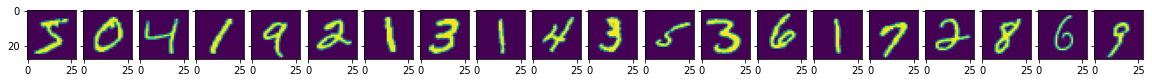

In [46]:
from mpl_toolkits.axes_grid1 import ImageGrid                         #To plot the images in grid and we have seen it befoer 
def plot_digits(data):
    num_plots = data.shape[0]
    fig = plt.figure(figsize=(num_plots, 10.*num_plots))
    grid = ImageGrid(fig, 111, nrows_ncols=(1, num_plots), axes_pad=0.1)
    for i in range(num_plots):
        grid[i].imshow(data[i].reshape((28,28)))
    plt.show()
plot_digits(xm[:20])                                                  #plot to visualize the dataset 

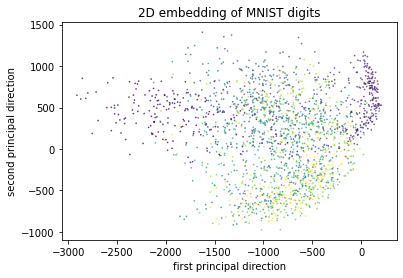

In [47]:
x_small = xm[:2000]                                                      # slice the first 2000 images
u, s, vt = np.linalg.svd(x_small-np.mean(x_small, axis=0))              # subtract the mean along the axis 0 and do svd
pcs = x_small @ vt.T                                                    # find the 2 principal components 
plt.scatter(pcs[:,0], pcs[:,1], c=ym[:2000], s=.5, alpha=.7)             # plot them  
plt.xlabel("first principal direction")
plt.ylabel("second principal direction")
plt.title("2D embedding of MNIST digits")
plt.show()

**Second example.**
Next let's only work with a single digit and more closely examine principal directions

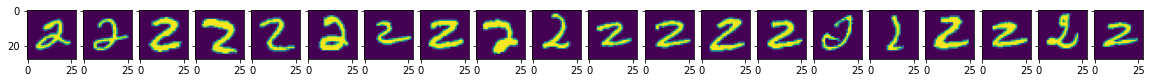

In [48]:
x2 = xm[ym.astype(int)==2, :]          #just slice 2 from the dataset 
plot_digits(x2[:20])

In [49]:
u, s, vt = np.linalg.svd(x2-np.mean(x2, axis=0))    #perform svd

Let's plot the first twenty principal directions

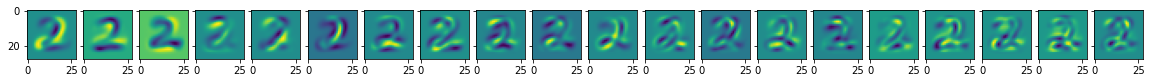

In [50]:
plot_digits(vt[:20])          #we plot the first 20 principal directions

We can also produce principal component coefficients for a new image:

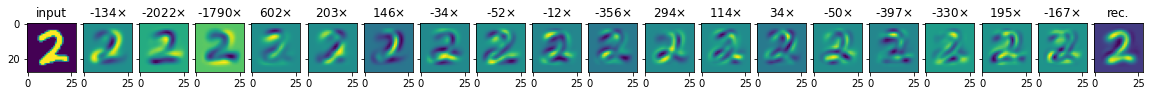

In [51]:
num_plots = 20
fig = plt.figure(figsize=(num_plots, 10.*num_plots))
grid = ImageGrid(fig, 111, nrows_ncols=(1, num_plots), axes_pad=0.1)
xn = x2[-1]                              # get the last image
coefs = xn @ vt.T                       # get the coefficients corresponding to the the first 20 principal directions
grid[0].imshow(xn.reshape((28,28)))
grid[0].set_title("input")
x_rec = np.zeros_like(xn)               # to store the reconstruction
for i in range(num_plots-2):
    coef = xn.dot(vt[i])
    grid[i+1].imshow(vt[i].reshape((28,28)))
    grid[i+1].set_title(f'{coef:.0f}'+r'$\times$')
    x_rec += coef * vt[i]               # add the coefficent times the principal components to get the reconstruction 
grid[-1].imshow(x_rec.reshape((28,28)))
grid[-1].set_title('rec.')
plt.show()

## How many principal components to use?
To choose this number we can look at the variance of the data that is explained by each additional principal component $\frac{1}{N} \sum_n ({x^{(n)}}^\top v_i)^2$. Let's plot this for our digits example.

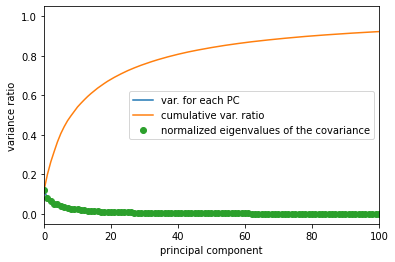

In [52]:
variances = np.var(x2 @ vt.T, axis=0)                                      # find the variance of the projected data along each principal component 
plt.plot(variances/np.sum(variances), label="var. for each PC")           # ratio of the variance along each principal direction
plt.plot(np.cumsum(variances/np.sum(variances)), label="cumulative var. ratio")
plt.xlabel("principal component")
plt.xlim([0,100])
plt.ylabel("variance ratio")
plt.plot((s**2)/(np.sum(s**2)), "o", label="normalized eigenvalues of the covariance")  # ratio of the eigen valures each principal direction 
#we see both the plots are the same
plt.legend()
plt.show()

In [53]:
print(f'total variance in the original and new coordinates are equal: {np.sum(np.var(x, 0))}={np.sum(variances)}')

total variance in the original and new coordinates are equal: 6.661986043513696=3294564.838249084


We make several observations from the plot above:
- since we have are using an orthogonal transformation the total variance is the same under change of coordinate
- however in the new coordinate, coordinates with large index do not see much variance in the data
- so we can use the explained variance for picking $D'$

# Outlier detection

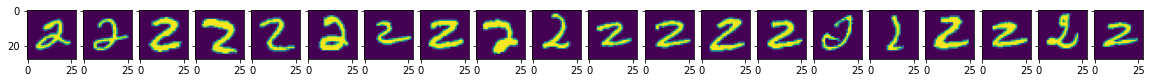

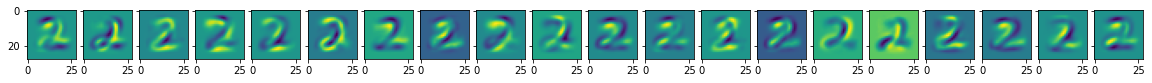

In [54]:
xo = xm[ym.astype(int)==2, :][:2000,:]
x_outliers = 1-xo[:2]                          #xorg[y.astype(int)==5, :][:]
x = np.row_stack((x_outliers,xo))
plot_digits(xo[:20])
u, s, vt = np.linalg.svd(xo-np.mean(xo,0))
pcs = x @ vt.T
rec = u[:,:10]@np.diag(s[:10])@vt[:10,:]
plot_digits(rec[:20])
plt.show()

## Low-rank approximation using SVD
Matrix factorization methods have many applications in machine learning. SVD enables us to produce a low-rank approximation of a matrix.

(427, 640)


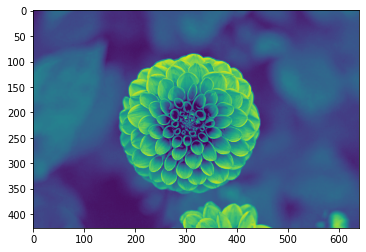

In [55]:
from sklearn.datasets import load_sample_images
dataset = load_sample_images()
first_img_data = dataset.images[1]
xf = first_img_data[:,:,1]
print(xf.shape)
plt.imshow(xf)
plt.show()

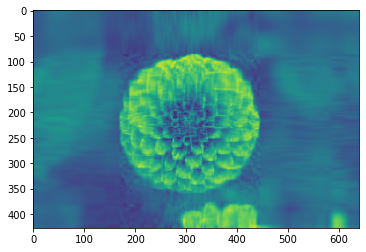

compression: from 273280 to 21340 
compression factor: 0.0780884074941452


In [56]:
u,s,vt = np.linalg.svd(xf, full_matrices=False)
#if the shape was x*y now we need to store x*rank + rank*y
rank = 20
uh, sh, vth = u[:,:rank], s[:rank], vt[:rank, :]      #slice the singular values for low dimentional storage
xh = uh @ np.diag(sh) @vth
#plt.imshow(vth)
#plt.imshow(uh @ np.diag(sh))
plt.imshow(xh)
plt.show()
print(f'compression: from {np.prod(xf.shape)} to {rank*np.sum(xf.shape)} \ncompression factor: {rank*np.sum(xf.shape)/np.prod(xf.shape)}')